# Equity Options Portfolio Optimization:
**Authors:** William Lester, Luke Rutherford, Dylan Kynoch, Henry Daniel \
**Start Date:** 4/17/2024 \
**Last Updated:** 4/19/2024

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import data_functions as dat_func, visualizations as vis
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [16]:
start_date,end_date="2022-01-01","2023-01-01"
start_date,end_date=pd.to_datetime(start_date),pd.to_datetime(end_date)
trade_dates=dat_func.get_trading_days(start_date,end_date)

tickers = ['XOM', 'WMT', 'GPC', 'OXY', 'PM', 'NNI', 'FI', 'ATKR', 'VICI', 'ADBE', 'AMAT', 'STLD']
#tickers = ['XOM', 'WMT', 'GPC','FI']
ex_stock='XOM'

[*********************100%%**********************]  12 of 12 completed


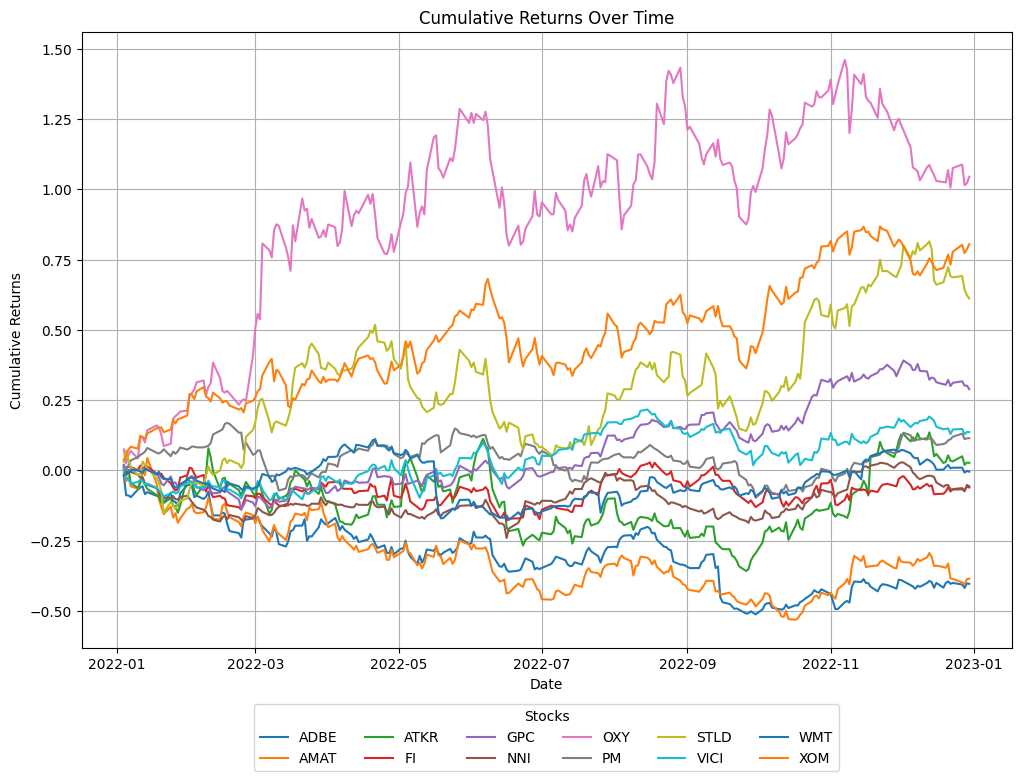

In [17]:
stock_df=dat_func.get_price_df(tickers,start_date,end_date)
returns_df=dat_func.get_log_returns(stock_df)
vis.plot_cumulative_returns(returns_df)

In [18]:
fred,poly=dat_func.connect_apis()
risk_free_rate=fred.get_series('GS10',start_date,start_date+pd.Timedelta(days=1))[0]/100

In [19]:
init_weights,init_ret,init_std=dat_func.get_init_port(returns_df,risk_free_rate)
init_weights=init_weights.round(3)
print('Initial Port Returns:',init_ret)
print('Initial Port Volatility:',init_std)
print('Initial Port Sharpe:',(init_ret-risk_free_rate)/init_std)
print('Optimal Weights:',dict(zip(returns_df.columns,init_weights)))

Initial Port Returns: 0.4987081619805882
Initial Port Volatility: 0.27261194170292097
Initial Port Sharpe: 1.7648095640097679
Optimal Weights: {'ADBE': 0.0, 'AMAT': 0.0, 'ATKR': 0.0, 'FI': 0.0, 'GPC': 0.259, 'NNI': 0.0, 'OXY': 0.039, 'PM': 0.0, 'STLD': 0.119, 'VICI': 0.0, 'WMT': 0.0, 'XOM': 0.583}


## Initial Portfolio Simulation:
### Geometric Brownian Motion: 

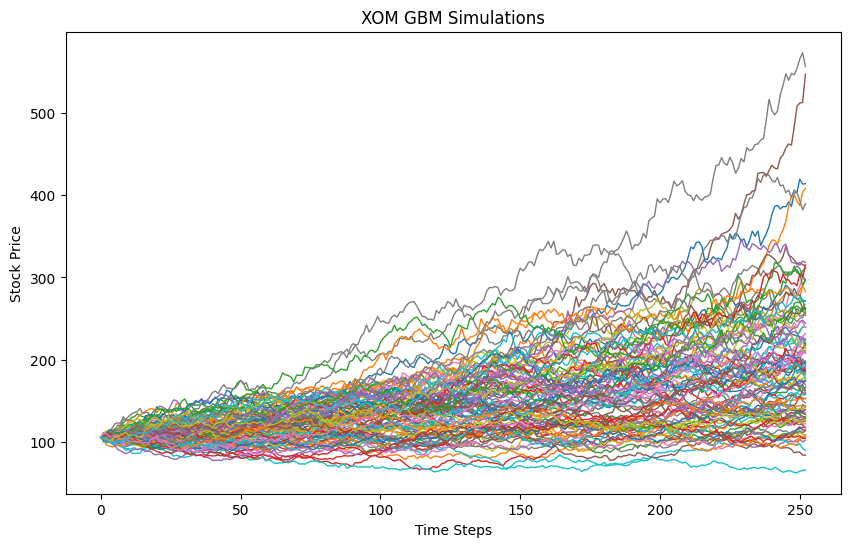

In [20]:
gpc_gbm=dat_func.simulate_gbm(stock_df[ex_stock][-1],returns_df.mean()[ex_stock]*252,returns_df.std()[ex_stock]*np.sqrt(252),1,N=100)
vis.plot_paths(gpc_gbm,f'{ex_stock} GBM',False)

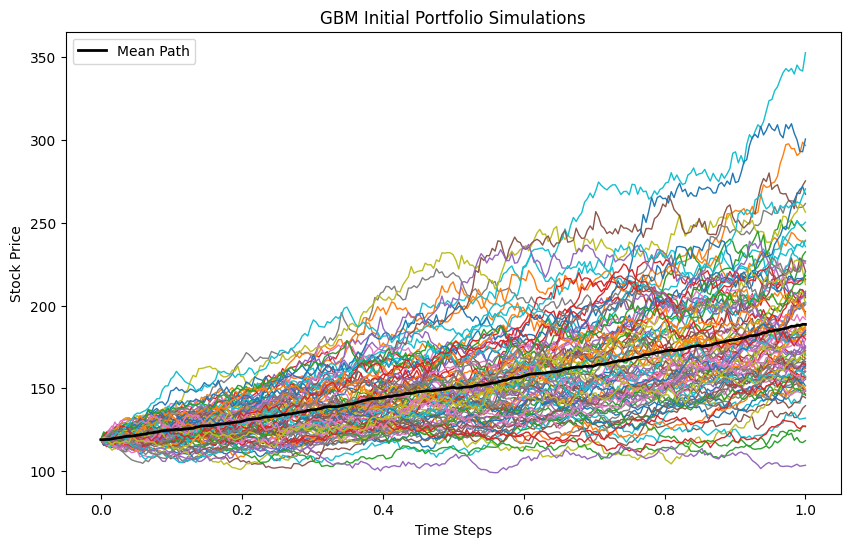

In [21]:
gbm_init_port=dat_func.simulate_gbm_portfolio(returns_df,stock_df,init_weights)
vis.plot_paths(gbm_init_port.iloc[:100],'GBM Initial Portfolio',True)

In [22]:
gbm_ret=(gbm_init_port.mean(axis=0).iloc[-1]-gbm_init_port.mean(axis=0).iloc[0])/gbm_init_port.mean(axis=0).iloc[0]

gbm_daily_vol = gbm_init_port.pct_change().dropna().std(axis=1)               # Daily standard deviation of returns
gbm_vol = np.sqrt(np.mean(gbm_daily_vol**2))  # Annualize the daily volatility

print(f'GBM Initial Portfolio Return: {round(gbm_ret*100,2)}%')
print(f'GBM Initial Portfolio Annual Volatility: {gbm_vol:.2%}')
print(f'GBM Initial Portfolio Sharpe: {gbm_ret/gbm_vol}')

GBM Initial Portfolio Return: 59.93%
GBM Initial Portfolio Annual Volatility: 13.60%
GBM Initial Portfolio Sharpe: 4.407194826811355


### Merton Jump Diffusion: 

In [23]:
# Estimate the number of jumps, mean jump, and vol of jumps
gpc_lambda_,gpc_m,gpc_v=dat_func.estimate_merton_params(returns_df[ex_stock])

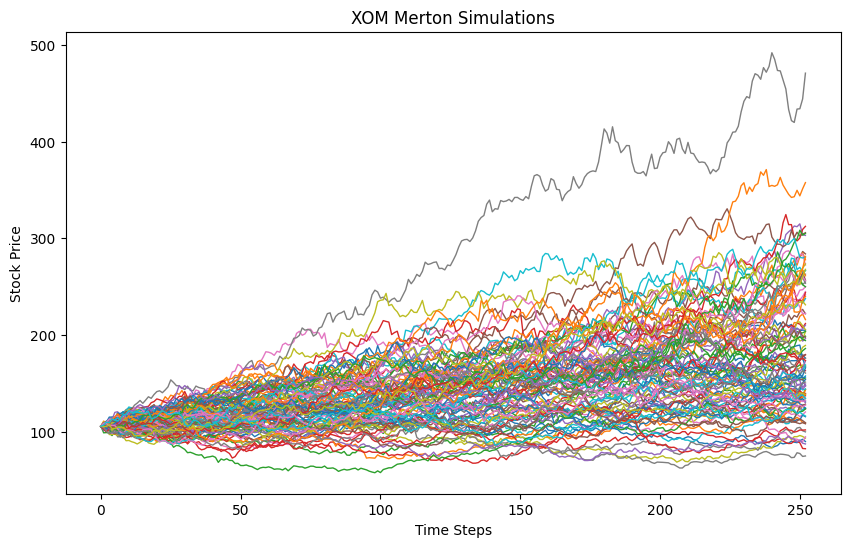

In [24]:
gpc_merton=dat_func.simulate_merton(stock_df[ex_stock][-1],returns_df.mean()[ex_stock]*252,returns_df.std()[ex_stock]*np.sqrt(252),1,gpc_lambda_,gpc_m,gpc_v,1/252,100)
vis.plot_paths(gpc_merton,f'{ex_stock} Merton')

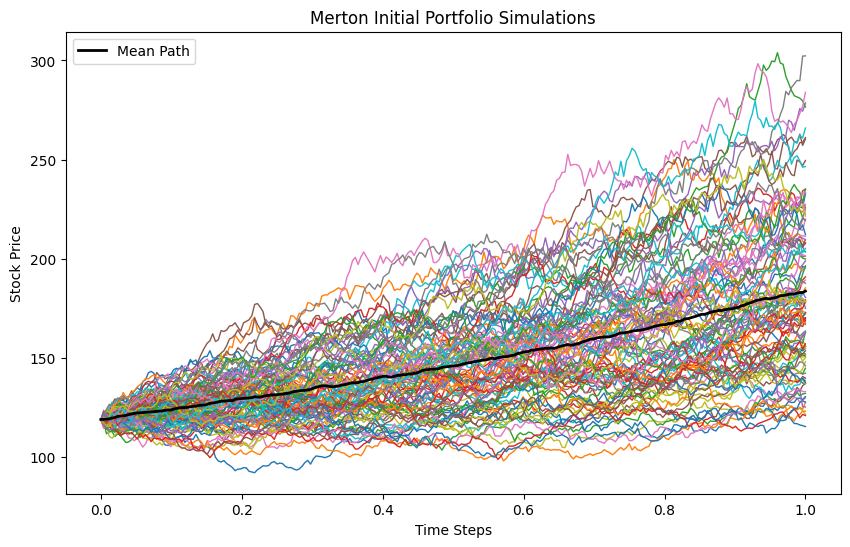

In [25]:
merton_init_port=dat_func.simulate_merton_portfolio(returns_df,stock_df,init_weights)
vis.plot_paths(merton_init_port.iloc[:100],'Merton Initial Portfolio',True)

In [26]:
merton_ret=(merton_init_port.mean(axis=0).iloc[-1]-merton_init_port.mean(axis=0).iloc[0])/merton_init_port.mean(axis=0).iloc[0]

merton_daily_vol = merton_init_port.pct_change().dropna().std(axis=1)
merton_vol = np.sqrt(np.mean(merton_daily_vol**2)) # RMS std (higher weight to outliers)

print(f'Merton Initial Portfolio Return: {round(merton_ret*100,2)}%')
print(f'Merton Initial Portfolio Annual Volatility: {merton_vol:.2%}')
print(f'Merton Initial Portfolio Sharpe: {merton_ret/merton_vol}')

Merton Initial Portfolio Return: 52.33%
Merton Initial Portfolio Annual Volatility: 14.00%
Merton Initial Portfolio Sharpe: 3.738781774235618


### Constant Elasticity of Variance (CEV): 

Estimated XOM CEV Parameters: mu=0.002184834445684717, std=0.2015714836430677, gamma=0.5013511669762731


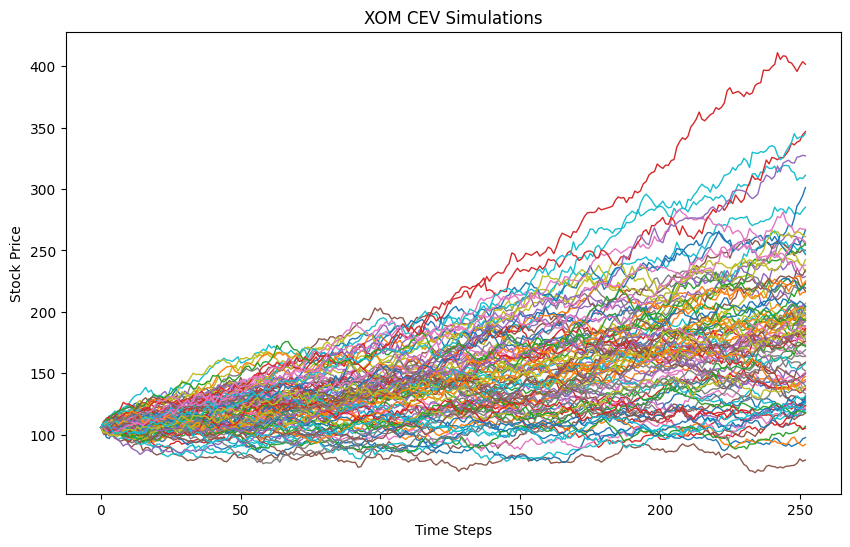

In [27]:
cev_ex_params=dat_func.estimate_cev_params(stock_series=stock_df[ex_stock])
simulated_prices = dat_func.simulate_cev(stock_df[ex_stock][-1],cev_ex_params[0]*252,cev_ex_params[1]*np.sqrt(252), gamma=cev_ex_params[2], T=1)
vis.plot_paths(simulated_prices[:100],f'{ex_stock} CEV')

Estimated ADBE CEV Parameters: mu=-0.001536188555907459, std=0.016253878007104892, gamma=1.0933910836347454
Estimated AMAT CEV Parameters: mu=-0.001197953785190125, std=0.015617775368856156, gamma=1.1528435576806924
Estimated ATKR CEV Parameters: mu=0.0009978559315110614, std=0.008272059661178553, gamma=1.3064916971984577
Estimated FI CEV Parameters: mu=-0.0004542371496203102, std=1.9040997243367823, gamma=0.0
Estimated GPC CEV Parameters: mu=0.0010383285201512789, std=0.6086850972011189, gamma=0.25326033090643657
Estimated NNI CEV Parameters: mu=-0.00036337972849982464, std=1.1507794336518449, gamma=0.0
Estimated OXY CEV Parameters: mu=0.0020016993443194232, std=0.34938690481613965, gamma=0.4251699136745352
Estimated PM CEV Parameters: mu=0.000432738425136329, std=0.16487833556207696, gamma=0.47492626365664004
Estimated STLD CEV Parameters: mu=0.0021050525325889895, std=0.08120895786830931, gamma=0.7579384162373444
Estimated VICI CEV Parameters: mu=0.0003937780425482801, std=0.4578555

c:\Users\willl\OneDrive\Docs\GitHub\Equity_Options_Port_Optimization\data_functions.py:214: RuntimeWarning: invalid value encountered in power
  S[:, i] = S[:, i-1] * (1 + mu * dt) + sigma * (S[:, i-1] ** gamma) * gaussian_increments[:, i-1] * sqrt_dt


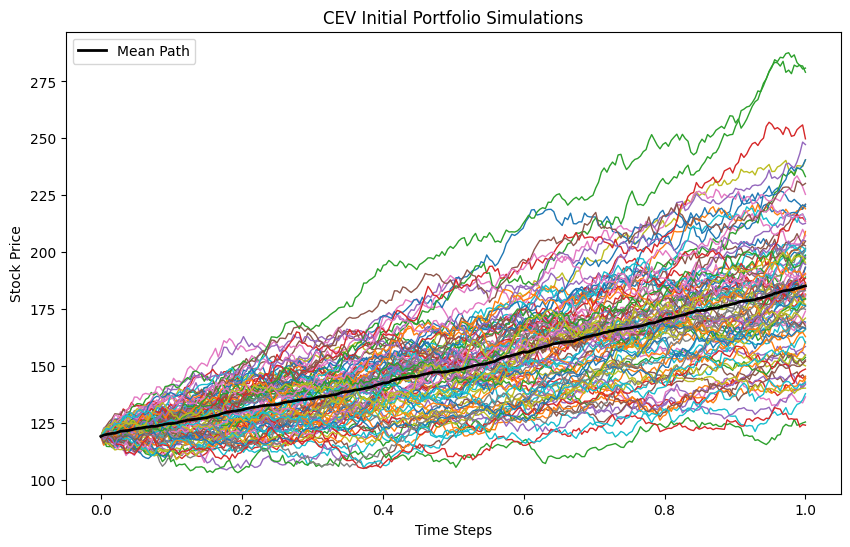

In [28]:
cev_init_port=dat_func.simulate_cev_portfolio(stock_df,init_weights)
vis.plot_paths(cev_init_port.iloc[:100],'CEV Initial Portfolio',True)

In [29]:
cev_ret=(cev_init_port.mean(axis=0).iloc[-1]-cev_init_port.mean(axis=0).iloc[0])/cev_init_port.mean(axis=0).iloc[0]

cev_daily_vol = cev_init_port.pct_change().dropna().std(axis=1)               # Daily standard deviation of returns
cev_vol = np.sqrt(np.mean(cev_daily_vol**2))  # Annualize the daily volatility

print(f'CEV Initial Portfolio Return: {round(cev_ret*100,2)}%')
print(f'CEV Initial Portfolio Annual Volatility: {cev_vol:.2%}')
print(f'CEV Initial Portfolio Sharpe: {cev_ret/cev_vol}')

CEV Initial Portfolio Return: 57.04%
CEV Initial Portfolio Annual Volatility: 10.37%
CEV Initial Portfolio Sharpe: 5.4987470992033565


### Heston Model: